In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from football_sim.football_sim import *
from football_sim.footystats import get_data_and_merge
import yaml
import os
%matplotlib inline

In [2]:
base_dir = '/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/Documents/football_sim'


#get_data_and_merge()

settings = Settings(os.path.join(base_dir, 'config.yaml'))



calibrator = Calibrator('2019-2020.pkl', settings,2019,redo=True)
calibrator.create_all_teams()
calibrator.process_data(verbose=False)


Force recalibrate
2019-2020.pkl  exists.
2020-07-08 07:57:32.046114 2019-10-12 07:57:32.046114


In [3]:
name = 'BPL'
league = Season(name, calibrator,use_home_advantage=False)
league.nr_cl = 4
print('home advantage',league.home_advantage)
data = calibrator.get_current_results(name)
league.process_current_results(data)
league.simulate_season(n_scenarios=int(1e5))
league.season_report()

home advantage 1
simulation not yet processed, processing


,Played,Points (current),Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Liverpool,33,89,99.6,95,104,1,1,100.0,100.00,5.03,0.27,0.00
Manchester City,33,66,78.4,74,81,2,2,0.0,100.00,5.87,0.26,0.00
Chelsea,34,60,66.6,63,70,5,3,0.0,75.12,4.28,0.34,0.00
Leicester City,34,59,65.6,61,69,6,3,0.0,66.41,3.92,0.36,0.00
Manchester United,33,55,65.0,60,70,6,3,0.0,54.17,4.40,0.32,0.00
Wolverhampton,33,52,60.2,56,65,8,5,0.0,4.18,3.28,0.29,0.00
Tottenham Hotspur,33,48,56.0,51,61,10,6,0.0,0.10,3.56,0.41,0.00
Arsenal,34,50,55.5,51,60,10,6,0.0,0.01,3.33,0.39,0.00
Sheffield United,33,48,53.5,49,58,12,7,0.0,0.02,2.72,0.38,0.00
Everton,33,44,52.0,47,57,13,8,0.0,0.00,3.30,0.37,0.00


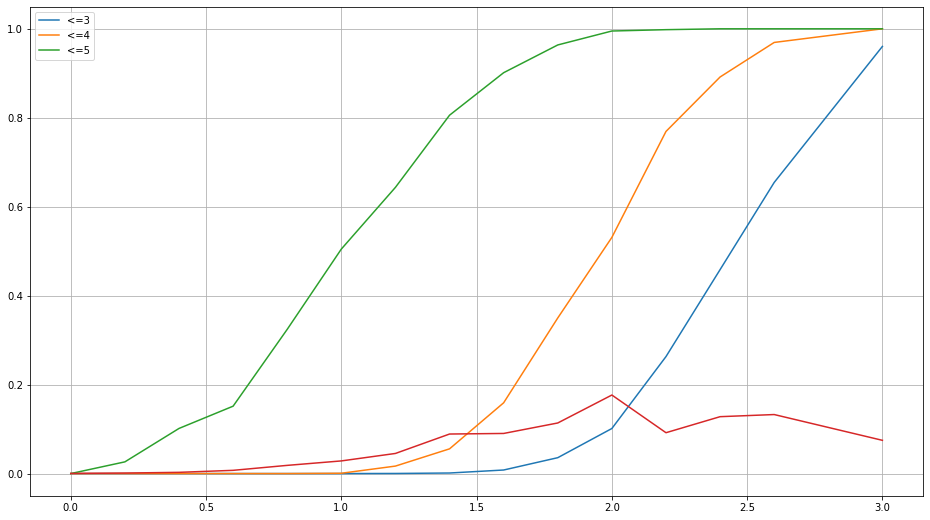

In [5]:

def plot_place_per_points(team_name,lgh):
    p0=league.current_points[team_name]

    i=league.team_id[team_name]

    #p0=league.current_points['Wolverhampton']
    #i = league.team_id['Wolverhampton']

    P=(league.points_per_team[i,:]-p0).astype(int)
    pp=np.unique(P)

    prob4=[]
    prob3=[]
    prob5=[]
    probp=[]
    for p in pp:
        ind =( P==p)
        probp.append(ind.sum()/ind.size)
        prob4.append(np.sum(league.place_per_team[i,ind]<=4)/ind.sum())
        prob3.append(np.sum(league.place_per_team[i,ind]<=3)/ind.sum())
        prob5.append(np.sum(league.place_per_team[i,ind]<=5)/ind.sum())

    C = len([x for x in league.matches_to_sim if team_name in x])
    #C=1
    plt.figure(figsize=(16,9))
    plt.plot(pp/C,prob3,label='<=3')
    plt.plot(pp/C,prob4,label='<=4')
    plt.plot(pp/C,prob5,label='<=5')
    plt.plot(pp/C,probp)
    plt.grid(True)
    plt.legend()
plot_place_per_points(league.teams['Manchester United'].name,league)
#plot_place_per_points(league.teams['Wolverhampton'].name,league)

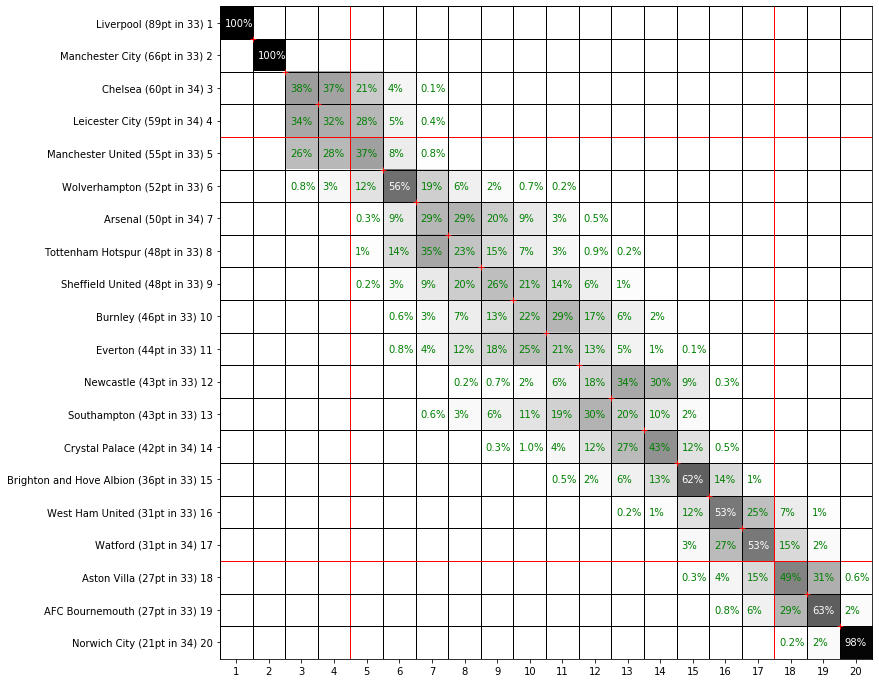

In [6]:
league.probability_grid();

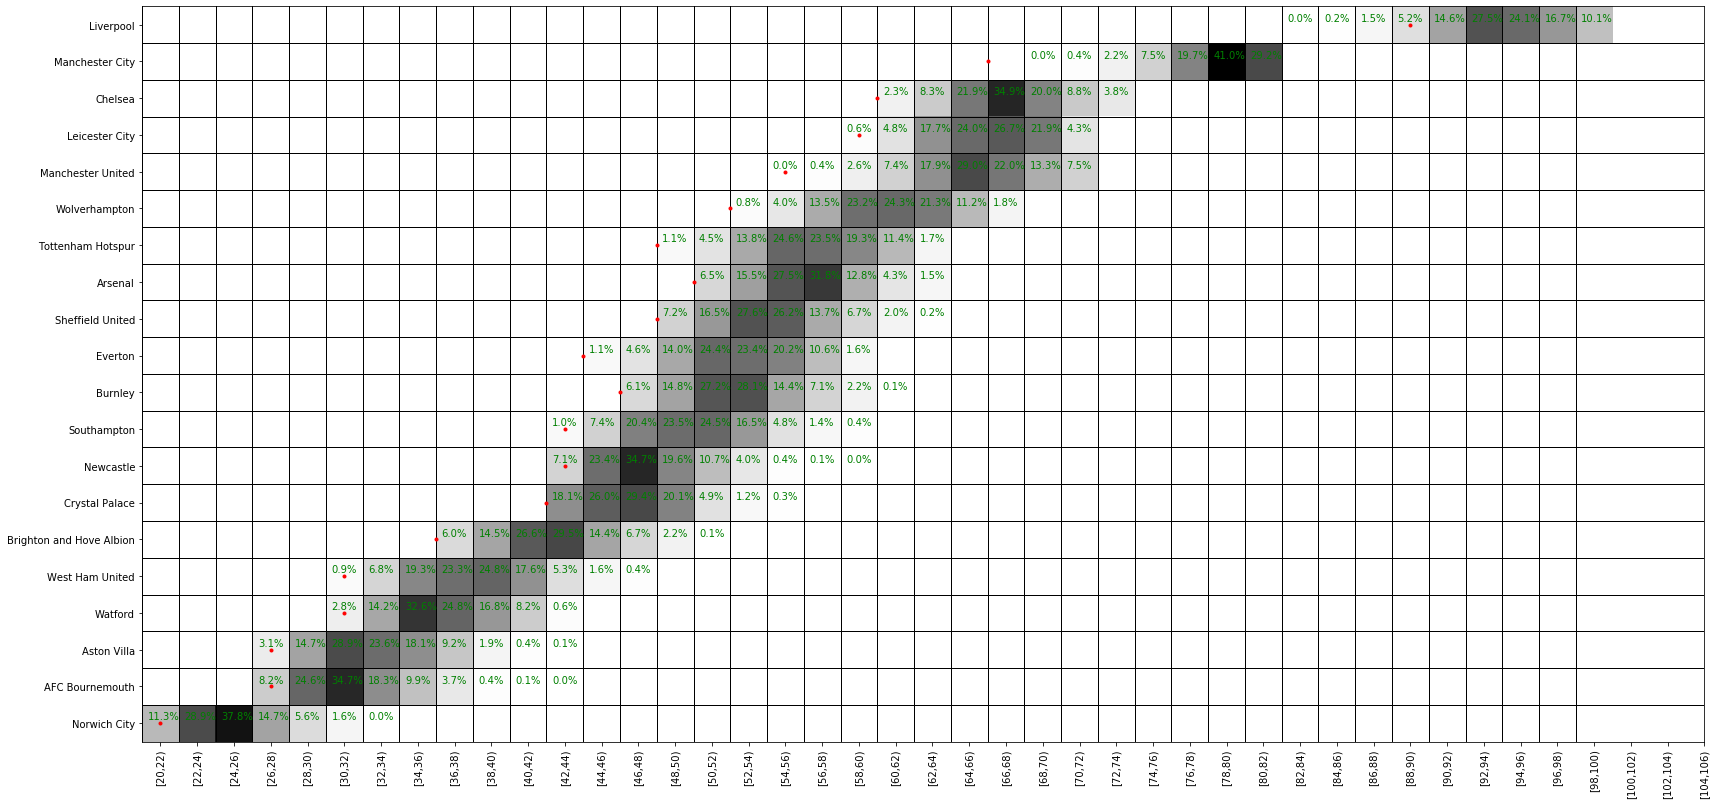

In [7]:
league.points_probability_grid();

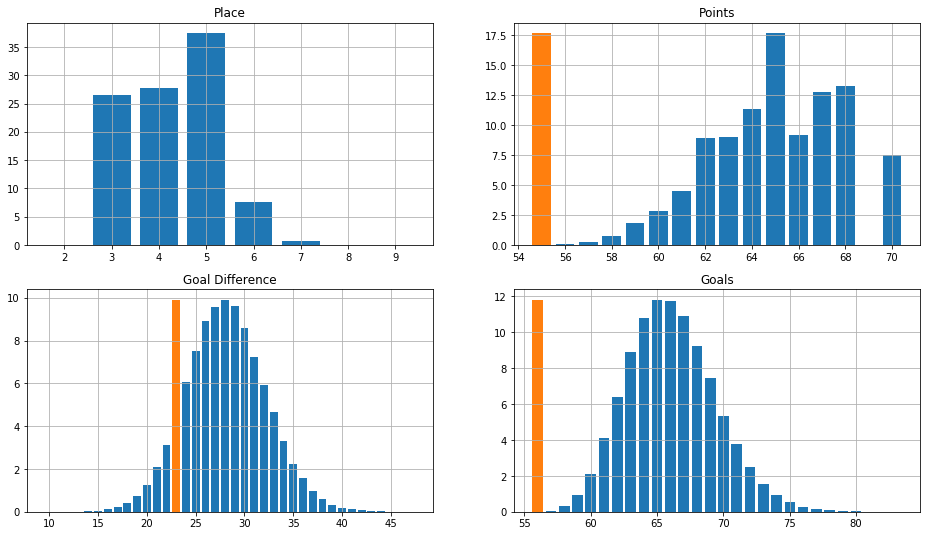

In [8]:
my_team = league.teams['Manchester United']

names = []
importance = []
for n,m in league.matches_to_sim.items():
    p=league.what_if(m,ref_team=my_team,place=4,or_better=True,show_plot=False)[0]
    names.append(n)
    importance.append(np.sum((p[1:]-p[0])**2))

names=np.array(names)
importance=np.array(importance)

isort = np.argsort(-importance)
names=names[isort]
importance=importance[isort]
league.team_report(my_team)

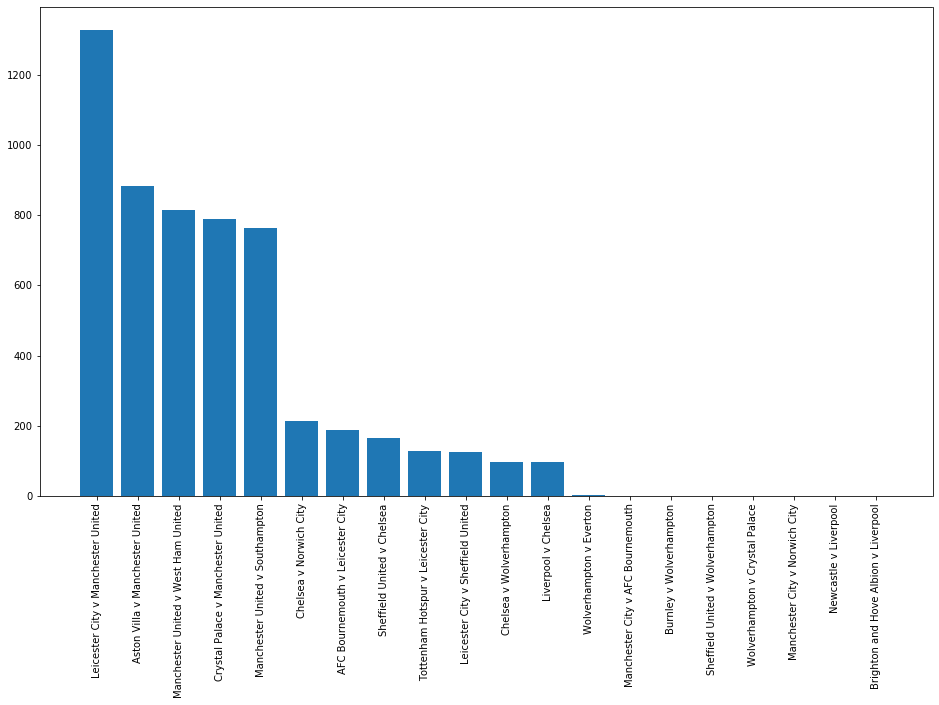

In [9]:
n_plot=20

plt.figure(figsize=(16,9))
plt.bar(np.arange(n_plot),importance[:n_plot])
plt.xticks(np.arange(n_plot),names[:n_plot],rotation=90);

(array([54.167     , 26.8363047 , 77.07647151, 46.85346058]),
 <Figure size 1152x648 with 1 Axes>)

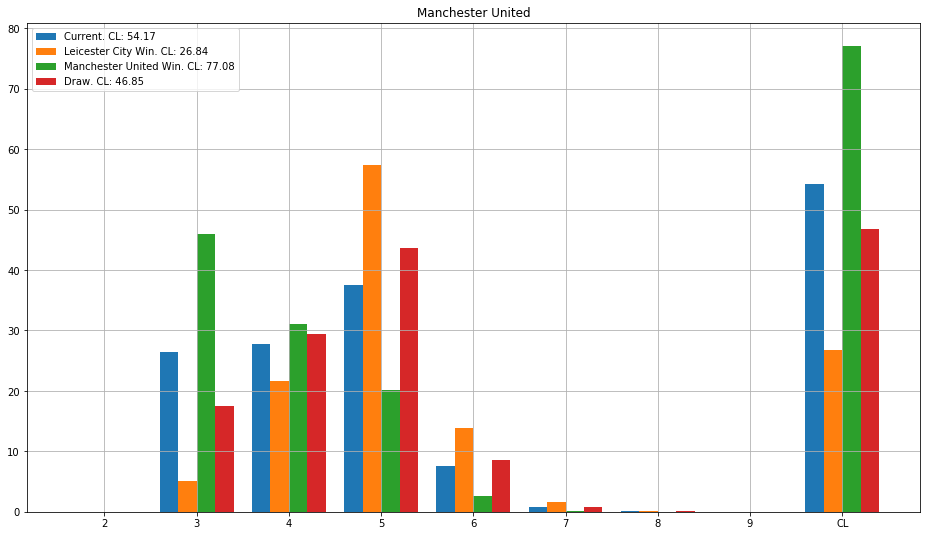

In [10]:
league.what_if(league.matches_to_sim['Leicester City v Manchester United'],ref_team=my_team,place=4,or_better=True)

In [11]:
match_id = league.matches_to_sim['Leicester City v Manchester United']['id']
hg= league.simulated_home_goals[match_id,:]
ag= league.simulated_away_goals[match_id,:]
ind = hg<ag
#i = league.team_id['Manchester United']
#j = league.team_id['Chelsea']


#ind = league.place_per_team[j,:]>league.place_per_team[i,:]

#i = league.team_id['Liverpool']
#ind = league.place_per_team[i,:]>1

print(ind.sum(),100*ind.sum()/ind.size)
league.season_report(ind=ind)

#name = 'Manchester United'
#ind = [x['id'] for x in league.matches_to_sim.values() if x['Home']==name]
#n=(league.simulated_home_goals[ind,:]<league.simulated_away_goals[ind,:]).sum(axis=0)
#ind = [x['id'] for x in league.matches_to_sim.values() if x['Away']==name]
#n+=(league.simulated_home_goals[ind,:]>league.simulated_away_goals[ind,:]).sum(axis=0)

#plt.bar(np.arange(20),100*np.bincount(n,minlength=20)/n.size);

44631 44.631


,Played,Points (current),Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Liverpool,33,89,99.6,95,104,1,1,100.0,100.00,5.03,0.27,0.00
Manchester City,33,66,78.4,74,81,2,2,0.0,100.00,5.87,0.26,0.00
Chelsea,34,60,66.6,63,70,5,3,0.0,73.55,4.28,0.34,0.00
Manchester United,33,55,66.5,62,70,5,3,0.0,77.08,4.40,0.32,0.00
Leicester City,34,59,64.4,60,68,6,3,0.0,45.16,3.92,0.36,0.00
Wolverhampton,33,52,60.2,56,65,8,5,0.0,4.06,3.28,0.29,0.00
Tottenham Hotspur,33,48,56.1,51,61,10,6,0.0,0.11,3.56,0.41,0.00
Arsenal,34,50,55.5,51,60,10,6,0.0,0.01,3.33,0.39,0.00
Sheffield United,33,48,53.5,49,58,12,7,0.0,0.03,2.72,0.38,0.00
Everton,33,44,52.0,47,57,13,8,0.0,0.00,3.30,0.37,0.00


In [ ]:
league.probability_grid();

In [ ]:
_date=[]
_home = []
_away = []
_best_pred = []
_best_pt = []
_most_lik = []
_most_lik_pts = []
_res_pred = []
_res_pred_pts = []
def res_fun(x):
    if x[0]>x[1]:
        return 0
    elif x[0]==x[1]:
        return 1
    else:
        return 2
for x in league.matches_to_sim.values():
    if pd.to_datetime(x['Date'])<= pd.to_datetime('2020-02-02'):
        
        home = calibrator.teams[x['Home']]
        away = calibrator.teams[x['Away']]
        n_scenarios = int(1e5)
        g = np.zeros([n_scenarios, 2])
        g[:, 0], g[:, 1], _ = home.vs(away, n=n_scenarios, home_advantage=league.home_advantage)
        p_home = (g[:,0]>g[:,1]).sum()/n_scenarios
        p_away = (g[:,0]<g[:,1]).sum()/n_scenarios
        p_draw = (g[:,0]==g[:,1]).sum()/n_scenarios
        res = np.argmax([p_home,p_draw,p_away])
        u, c = np.unique(g, axis=0, return_counts=True)
        loc = (-c).argsort()
        u = u[loc, :]
        c = c[loc]
        best_pt = 0
        best_pred = None
        def get_pts(pred):
            ind40 = (g[:,0]==pred[0])&(g[:,1]==pred[1])
            ind10 = (g[:,0]>g[:,1])&(pred[0]>pred[1])|(g[:,0]<g[:,1])&(pred[0]<pred[1])|(g[:,0]==g[:,1])&(pred[0]==pred[1])
            points = np.zeros(n_scenarios)
            points[ind10]=10
            points[ind40]=40
            return [points.mean()]
        res_pred = None
        for i in range(20):
            _pred = u[i,:].astype(int)
            pts = get_pts(_pred)
            if (res_pred is None) and res_fun(_pred)==res:
                res_pred = _pred
                
            if i == 0:
                most_likely_pt = pts
            if pts[0]>best_pt:
                best_pred = _pred.astype(int)
                best_pt = pts[0]
        _date.append(x['Date'])
        _home.append(x['Home'])
        _away.append(x['Away'])
        _best_pred.append(best_pred)
        _best_pt.append(get_pts(best_pred)[0])
        _most_lik.append(u[0,:].astype(int))
        _most_lik_pts.append(get_pts(u[0,:])[0])
        _res_pred.append(res_pred)
        _res_pred_pts.append(get_pts(res_pred)[0])
        
        #print(x['Date'],'|',x['Home'],'v',x['Away'])
        #print(best_pred,':',get_pts(best_pred),'|',u[0,:],':',most_likely_pt,'|',g.mean(axis=0),get_pts(np.round(g.mean(axis=0))))
        #print('-'*100)


In [ ]:
#df=pd.DataFrame({'date':_date,'home':_home,'away':_away,'best pred':_best_pred,' bestpoints':_best_pt,
#                'MLS':_most_lik,'MLS points':_most_lik_pts})
df=pd.DataFrame({'date':_date,'home':_home,'away':_away,'best pred':_best_pred,' bestpoints':_best_pt,
                'RP':_res_pred,'RP points':_res_pred_pts,'MLS':_most_lik,'MLS points':_most_lik_pts,
                 'actual_score':['[h, a]']*len(_date),'points earned':[0]*len(_date)})
df=df.sort_values(by='date')
df.to_csv('/Users/manuel/Desktop/predictions/predictions.csv',index=False)
df

In [ ]:
for i in range(50):
    _pred = u[i,:]
    pts = get_pts(_pred)
    plt.plot(pts[0],pts[1],'.')